In [1]:
import pmcpy
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## comparison with `urban_plume_process.F90`

In [2]:
# define the path to data
p = "../data/"

### pmcpy 

In [3]:
group_list = [["OC","BC"],
              ["API1","API2","LIM1","LIM2"],
              ["SO4","NO3","NH4"]]
d = {"tot_num_conc": [], "tot_mass_conc":[], 
     "chi":[], "d_alpha":[], "d_gamma":[],
     "chi_a":[], "d_alpha_a":[], "d_gamma_a":[]}

for i in range(1,26):
    pmc = pmcpy.load_pmc(p+"/urban_plume_0001_000000"+str(i).zfill(2)+".nc")
    
    D_alpha, D_gamma, chi = pmc.get_mixing_state_index(group_list, diversity=True)
    D_alpha_a, D_gamma_a, chi_a = pmc.get_mixing_state_index(drop_list=["H2O"], diversity=True)
    
    d["d_alpha"].append(D_alpha)
    d["d_gamma"].append(D_gamma)
    d["chi"].append(chi)
    d["d_alpha_a"].append(D_alpha_a)
    d["d_gamma_a"].append(D_gamma_a)
    d["chi_a"].append(chi_a)
    d["tot_num_conc"].append(pmc.tot_num_conc())
    d["tot_mass_conc"].append(pmc.tot_mass_conc())

### load the benchmark from Fortran code and compare

tot_num_conc


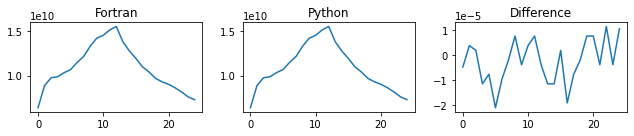

tot_mass_conc


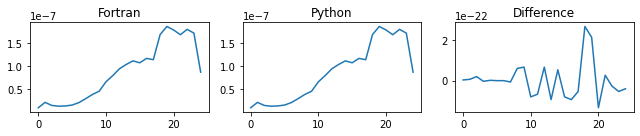

chi


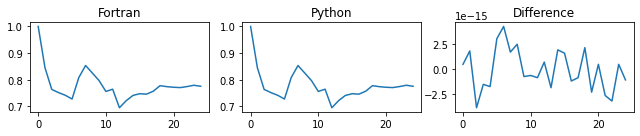

d_alpha


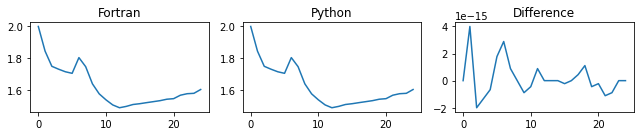

d_gamma


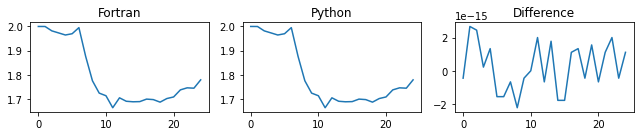

chi_a


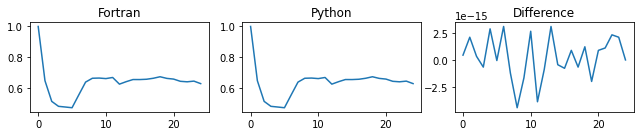

d_alpha_a


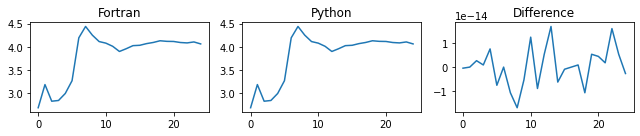

d_gamma_a


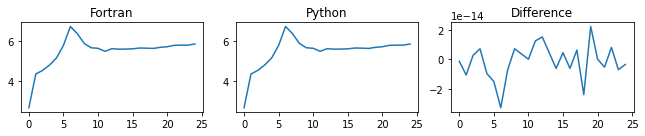

In [4]:
ds_b = xr.open_dataset(p+"urban_plume_process.nc")

for k in d:
    print(k)
    fig = plt.figure(figsize=(9,2))
    ax1 = fig.add_subplot(131)
    pd.Series(ds_b[k].values).plot(ax=ax1)
    ax1.set_title("Fortran")

    ax2 = fig.add_subplot(132)
    pd.Series(d[k]).plot(ax=ax2)
    ax2.set_title("Python")

    ax3 = fig.add_subplot(133)
    pd.Series(ds_b[k].values-np.array(d[k])).plot(ax=ax3)
    ax3.set_title("Difference")
    
    plt.tight_layout()
    plt.show()

## read gas species

In [5]:
print("H2SO4:",pmc.gas_dict["H2SO4"])
print("O3:",pmc.gas_dict["O3"])
pmc.get_gas_conc(["H2SO4","O3"]).to_dataframe()

H2SO4: 1
O3: 11


,gas_mixing_ratio
gas_species,
1,0.000055
11,71.838941
